# Window Functions - Rolling and Expanding Metrics
> A Summary of lecture "Manipulating Time Series Data in Python", via datacamp

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Time_Series_Analysis]
- image: images/stock_heatmap.png

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)

## Rolling window function with pandas
- window functions in pandas
    - Windows identify sub periods of your time series
    - Calculate metrics for sub periods inside the window
    - Create a new time series of metrics
    - Two types of windows
        - Rolling: same size, sliding
        - Expanding: Contain all prior values

### Rolling average air quality since 2010 for new york city
The last video was about rolling window functions. To practice this new tool, you'll start with air quality trends for New York City since 2010. In particular, you'll be using the daily Ozone concentration levels provided by the Environmental Protection Agency to calculate & plot the 90 and 360 day rolling average.



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6291 entries, 2000-01-01 to 2017-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozone   6167 non-null   float64
dtypes: float64(1)
memory usage: 98.3 KB
None


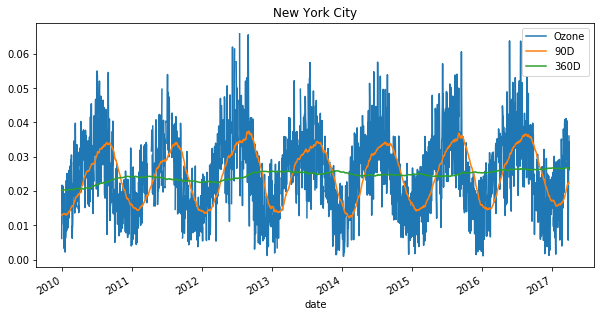

In [2]:
# import and inspect ozone data here
data = pd.read_csv('./dataset/ozone_nyc.csv', parse_dates=['date'], index_col='date')
print(data.info())

# Calculate 90d and 360d rolling mean for the last price
data['90D'] = data['Ozone'].rolling('90D').mean()
data['360D'] = data['Ozone'].rolling('360D').mean()

# Plot data
data.loc['2010':].plot(title='New York City');

### Rolling 360-day median & std. deviation for nyc ozone data since 2000
The last video also showed you how to calculate several rolling statistics using the ```.agg()``` method, similar to ```.groupby()```.

Let's take a closer look at the air quality history of NYC using the Ozone data you have seen before. The daily data are very volatile, so using a longer term rolling average can help reveal a longer term trend.

You'll be using a 360 day rolling window, and ```.agg()``` to calculate the rolling mean and standard deviation for the daily average ozone values since 2000.

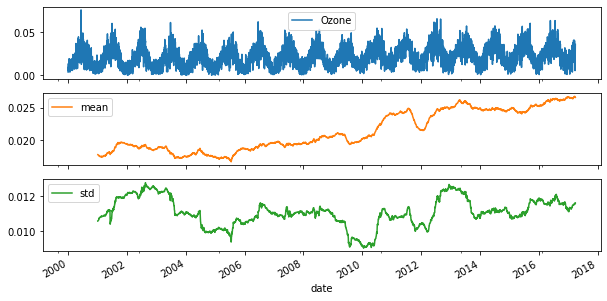

In [3]:
data = pd.read_csv('./dataset/ozone_nyc.csv', parse_dates=['date'], index_col='date').dropna()

# Calculate the rolling mean and std here
rolling_stats = data['Ozone'].rolling(360).agg(['mean', 'std'])

# Join rolling_stats with ozone data
stats = data.join(rolling_stats)

# Plot data
stats.plot(subplots=True);

### Rolling quantiles for daily air quality in nyc
You learned in the last video how to calculate rolling quantiles to describe changes in the dispersion of a time series over time in a way that is less sensitive to outliers than using the mean and standard deviation.

Let's calculate rolling quantiles - at 10%, 50% (median) and 90% - of the distribution of daily average ozone concentration in NYC using a 360-day rolling window.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6300 entries, 2000-01-01 to 2017-03-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozone   6300 non-null   float64
dtypes: float64(1)
memory usage: 98.4 KB
None


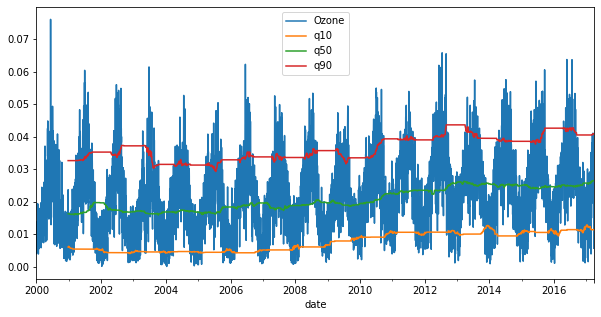

In [4]:
# Resample, interpolate and inspect ozone data here
data = data.resample('D').interpolate()
print(data.info())

# Create the rolling window
rolling = data['Ozone'].rolling(360)

# Insert the rolling quantiles to the monthly returns
data['q10'] = rolling.quantile(0.1).to_frame('q10')
data['q50'] = rolling.quantile(0.5).to_frame('q50')
data['q90'] = rolling.quantile(0.9).to_frame('q90')

# Plot the data
data.plot()

## Expanding window functions with pandas
- Expanding windows in pandas
    - From rolling to expanding windows
    - Calculate metrics for periods up to current date
    - New time series reflects all historical values
    - Useful for running rate of return, running min/max
    - Two options with pandas:
        - ```.expanding()```
        - ```.cumsum()```,```.cumprod()```,```.cummin()```, ```.cummax()```
- How to calculate a running return
    - Single period return $r_t$: current prince over last price minus 1:
    $$ r_t = \frac{P_t}{P_{t-1}} - 1 $$
    - Multi-period return: product of ($1 + r_t$) for all periods, minus 1:
    $$ R_T = (1 + r_1)(1 + r_2) \dots (1 + r_T) - 1 $$

### Cumulative sum vs .diff()
In the video, you have learned about expanding windows that allow you to run cumulative calculations.

The cumulative sum method has in fact the opposite effect of the ```.diff()``` method that you came across in chapter 1.

To illustrate this, let's use the Google stock price time series, create the differences between prices, and reconstruct the series using the cumulative sum.

In [5]:
data = pd.read_csv('./dataset/google.csv', parse_dates=['Date'], index_col='Date').dropna()

In [6]:
# Calculate differences
differences = data.diff().dropna()

# Select start price
start_price = data.first('D')

# Calculate cumulative sum
cumulative_sum = start_price.append(differences).cumsum()

# Validate cumulative sum equals data
print(data.equals(cumulative_sum))

True


### Cumulative return on $ 1,000 invested in google vs apple I
To put your new ability to do cumulative return calculations to practical use, let's compare how much $1,000 would be worth if invested in Google ('GOOG') or Apple ('AAPL') in 2010.


In [7]:
data = pd.read_csv('./dataset/apple_google.csv', parse_dates=['Date'], index_col='Date')

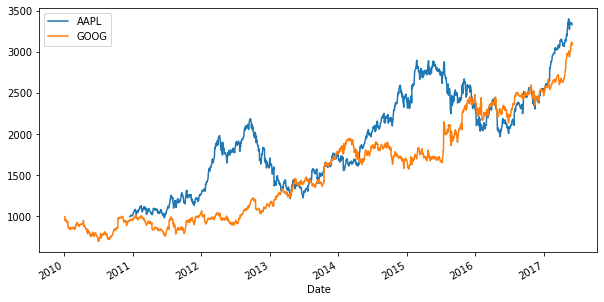

In [8]:
# Define your investment
investment = 1000

# Calculate the daily returns here
returns = data.pct_change()

# Calculate the cumulative returns here
returns_plus_one = returns + 1
cumulative_return = returns_plus_one.cumprod()

# Calculate and plot the investment return here
cumulative_return.mul(investment).plot();

### Cumulative return on $ 1,000 invested in google vs apple II
Apple outperformed Google over the entire period, but this may have been different over various 1-year sub periods, so that switching between the two stocks might have yielded an even better result.

To analyze this, calculate that cumulative return for rolling 1-year periods, and then plot the returns to see when each stock was superior.


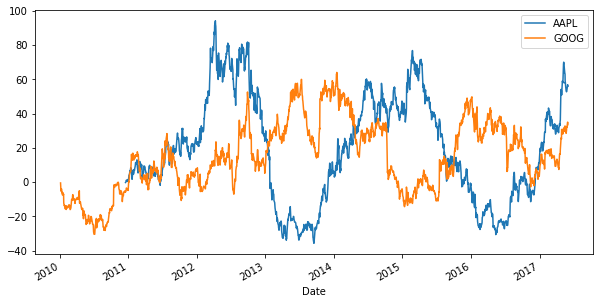

In [9]:
# Define a multi_period_return function
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

# Calculate daily returns
daily_returns = data.pct_change()

# Calculate rolling_annual_returns
rolling_annual_returns = daily_returns.rolling('360D').apply(multi_period_return)

# Plot rolling_annual_returns
rolling_annual_returns.mul(100).plot();

## Case study: S&P500 price simulation
- Random walks & simulations
    - Daily stock returns are hard to predict
    - Models often assume they are random in nature
    - Numpy allows you to generate random numbers
    - From random returns to prices: use ```.cumprod()```
    - Two examples:
        - Generate random returns
        - Randomly selected actual SP500 returns

### Random walk I
In the last video, you have seen how to generate a random walk of returns, and how to convert this random return series into a random stock price path.

In this exercise, you'll build your own random walk by drawing random numbers from the normal distribution with the help of numpy.

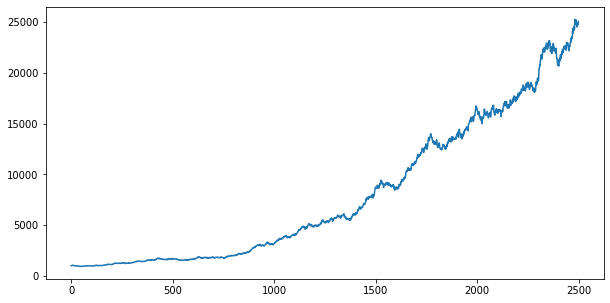

In [10]:
# Set seed here
np.random.seed(42)

# Create random_walk
random_walk = np.random.normal(loc=0.001, scale=0.01, size=2500)

# Convert random_walk to pd.series
random_walk = pd.Series(random_walk)

# Create random_prices
random_prices = random_walk.add(1).cumprod()

# Plot random_prices
random_prices.mul(1000).plot();

### Random walk II
In the last video, you have also seen how to create a random walk of returns by sampling from actual returns, and how to use this random sample to create a random stock price path.

In this exercise, you'll build a random walk using historical returns from Facebook's stock price since IPO through the end of May 31, 2017. Then you'll simulate an alternative random price path in the next exercise.

In [11]:
fb = pd.read_csv('./dataset/fb.csv', header=None, index_col=0)
fb.index = pd.to_datetime(fb.index)
fb.index = fb.index.rename('date')
fb.columns = ['price']

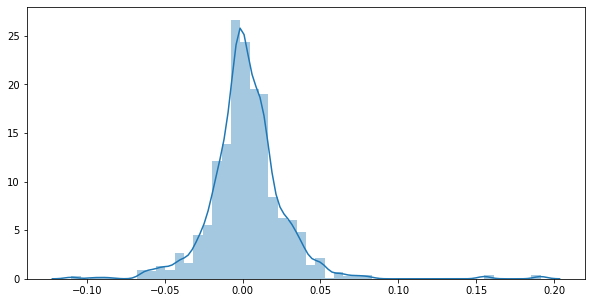

In [12]:
# Set seed here
np.random.seed(42)

# Calculate daily_returns here
daily_returns = fb['price'].pct_change().dropna()

# Get n_obs
n_obs = daily_returns.count()

# Create random_walk
random_walk = np.random.choice(daily_returns, size=n_obs)

# Convert random_walk to pd.Series
random_walk = pd.Series(random_walk)

# Plot random_walk distribution
sns.distplot(random_walk);

### Random walk III
In this exercise, you'll complete your random walk simulation using Facebook stock returns over the last five years. You'll start off with a random sample of returns like the one you've generated during the last exercise and use it to create a random stock price path.

In [13]:
random_walk = pd.read_csv('./dataset/random_walk.csv', header=None, index_col=0)
date_range = pd.date_range(start=fb.index[1], periods= len(fb) - 1, freq='B')
random_walk.index = date_range
random_walk = pd.Series(random_walk[1])

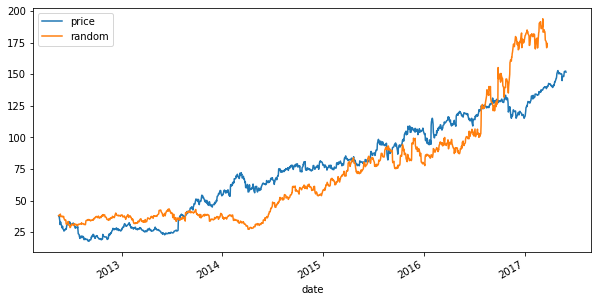

In [14]:
# Select fb start price here
start = fb['price'].first('D')

# Add 1 to random walk and append to start
random_walk = random_walk.add(1)
random_price = start.append(random_walk)

# Calculate cumulative product here
random_price = random_price.cumprod()

# Insert into fb and plot
fb['random'] = random_price
fb.plot();

## Relationships between time series: correlation
- Correlation & relations between series
    - So far, focus on characteristics of individual variables
    - Now: characheristic of relations between variables
    - Correlation: measures linear relationships
    - Financial markets: important for prediction and risk management
- Correlation & linear relationships
    - Correlation coefficient: how similar is the pairwise movement of two variables around their averages?
    - Varies between $-1$ and $+1$:
    $$ r = \frac{\sum_{i=1}^{N}(x_i - \bar{x})(y_i - \bar{y})}{s_x s_y} $$
![corr](image/corr.png)

### Annual return correlations among several stocks
You have seen in the video how to calculate correlations, and visualize the result.

In this exercise, we have provided you with the historical stock prices for Apple (```AAPL```), Amazon (```AMZN```), IBM (```IBM```), WalMart (```WMT```), and Exxon Mobile (```XOM```) for the last 4,000 trading days from July 2001 until the end of May 2017.

You'll calculate the year-end returns, the pairwise correlations among all stocks, and visualize the result as an annotated heatmap.

In [15]:
data = pd.read_csv('./dataset/5_stocks.csv', parse_dates=['Date'], index_col='Date')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4001 entries, 2001-07-05 to 2017-05-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    4000 non-null   float64
 1   AMZN    4000 non-null   float64
 2   IBM     4000 non-null   float64
 3   WMT     4000 non-null   float64
 4   XOM     4000 non-null   float64
dtypes: float64(5)
memory usage: 187.5 KB
None
          AAPL      AMZN       IBM       WMT       XOM
AAPL  1.000000  0.208731  0.460568 -0.183553  0.336413
AMZN  0.208731  1.000000  0.346407 -0.367620 -0.133965
IBM   0.460568  0.346407  1.000000  0.155445  0.367253
WMT  -0.183553 -0.367620  0.155445  1.000000  0.178833
XOM   0.336413 -0.133965  0.367253  0.178833  1.000000


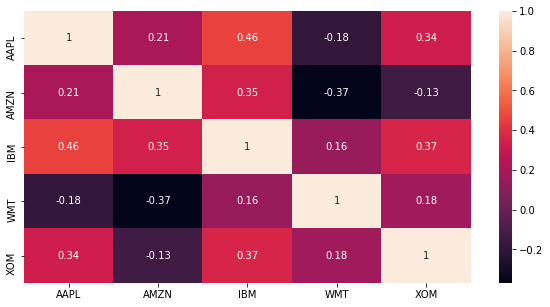

In [17]:
# Inspect data here
print(data.info())

# Calculate year-end prices here
annual_prices = data.resample('A').last()

# Calculate annual returns here
annual_returns = annual_prices.pct_change()

# Calculate and print the correlation matrix here
correlations = annual_returns.corr()
print(correlations)

# Visualize the correlations as heatmap here
sns.heatmap(correlations, annot=True);
plt.savefig('../images/stock_heatmap.png')